In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from arch.unitroot import DFGLS
# from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
import scipy 
from statsmodels.tsa.api import VAR

In [2]:
warnings.filterwarnings('ignore')

asset_tickers = ['GOOG', 'AAPL', 'MET', 'AMZN', 'MSFT', 'BTC-USD', 'GC=F', '^VIX', '^TNX', 'DX-Y.NYB', '^GSPC']

# Extract daily closing prices of the 100 stocks for 120 weeks
end_date = dt.datetime.now()
start_date = '2014-09-17'

def get_weekly_price_close(tickers):
    """
    Fetches monthly 'Close' prices of tickers provided, using yfinance
    """
    raw_data = yf.download(asset_tickers, period="1d", start=start_date, end=end_date)
    daily_close = raw_data['Close']
    # Resample into monthly and delete the latest month
    weekly_close = daily_close.fillna(method='ffill').resample('w').first()
    
    return weekly_close
    
df_raw = get_weekly_price_close(asset_tickers)

[*********************100%%**********************]  11 of 11 completed


In [3]:
print(df_raw.head())

# Download and save the data
df_raw.to_excel('D:/大学/ZEMI/4th year finance/raw_data.xlsx')

                 AAPL       AMZN     BTC-USD   DX-Y.NYB         GC=F  \
Date                                                                   
2014-09-21  25.395000  16.200001  457.334015  84.699997  1234.400024   
2014-09-28  25.264999  16.225000  402.152008  84.669998  1216.800049   
2014-10-05  25.027500  16.091000  375.467010  85.589996  1217.500000   
2014-10-12  24.905001  16.110001  330.079010  85.709999  1206.699951   
2014-10-19  24.952499  15.322500  390.414001  85.430000  1229.300049   

                 GOOG        MET       MSFT        ^GSPC   ^TNX       ^VIX  
Date                                                                        
2014-09-21  29.158445  49.269161  46.520000  2001.569946  2.600  12.650000  
2014-09-28  29.288090  49.215687  47.060001  1994.290039  2.566  13.690000  
2014-10-05  28.739098  48.048126  46.439999  1977.800049  2.491  15.980000  
2014-10-12  28.788462  47.228165  46.090000  1964.819946  2.425  15.460000  
2014-10-19  26.587503  43.645275 

In [4]:
data = pd.read_excel("D:/大学/ZEMI/4th year finance/raw_data.xlsx", index_col='Date')

data.head()

AAPL       AMZN     BTC-USD   DX-Y.NYB         GC=F  \
Date                                                                   
2014-09-21  25.395000  16.200001  457.334015  84.699997  1234.400024   
2014-09-28  25.264999  16.225000  402.152008  84.669998  1216.800049   
2014-10-05  25.027500  16.091000  375.467010  85.589996  1217.500000   
2014-10-12  24.905001  16.110001  330.079010  85.709999  1206.699951   
2014-10-19  24.952499  15.322500  390.414001  85.430000  1229.300049   

                 GOOG        MET       MSFT        ^GSPC   ^TNX       ^VIX  
Date                                                                        
2014-09-21  29.158445  49.269161  46.520000  2001.569946  2.600  12.650000  
2014-09-28  29.288090  49.215687  47.060001  1994.290039  2.566  13.690000  
2014-10-05  28.739098  48.048126  46.439999  1977.800049  2.491  15.980000  
2014-10-12  28.788462  47.228165  46.090000  1964.819946  2.425  15.460000  
2014-10-19  26.587503  43.645275  43.650002  1874.739990  2.286  24.639999

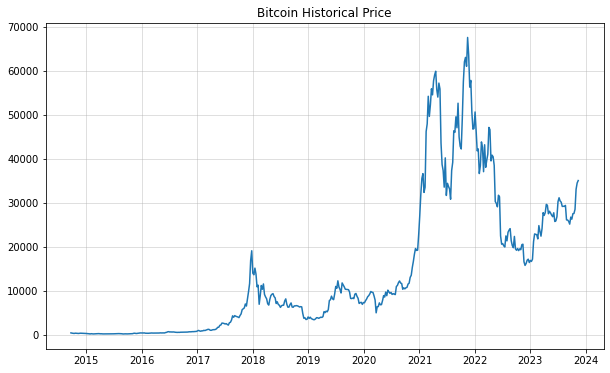

In [5]:
plt.figure(figsize=(10,6))
plt.plot(data['BTC-USD'])
plt.title('Bitcoin Historical Price')
plt.grid(1, alpha=0.5)
plt.show()

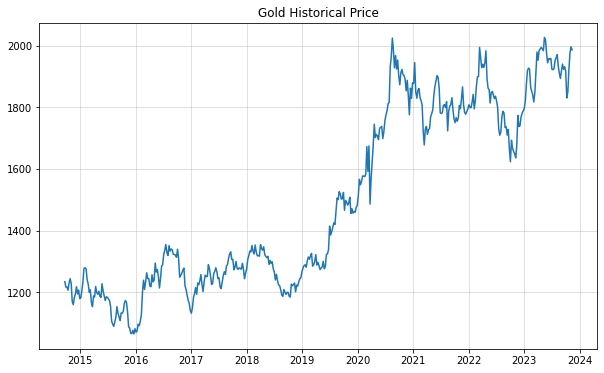

In [6]:
plt.figure(figsize=(10,6))
plt.plot(data['GC=F'])
plt.title('Gold Historical Price')
plt.grid(1, alpha=0.5)
plt.show()

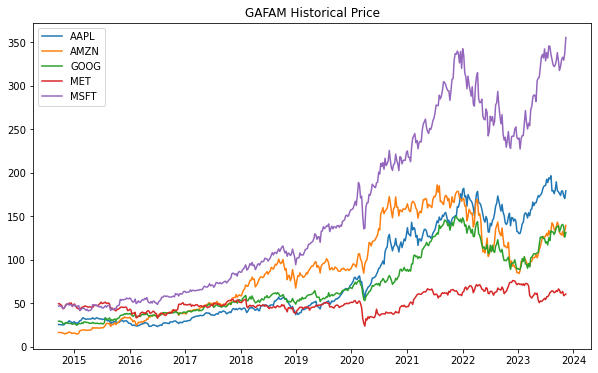

In [7]:
GAFAM = data[['AAPL', 'AMZN', 'GOOG', 'MET', 'MSFT']]

plt.figure(figsize=(10,6))
plt.plot(GAFAM)
plt.title('GAFAM Historical Price')
plt.legend(GAFAM.columns)
plt.show()

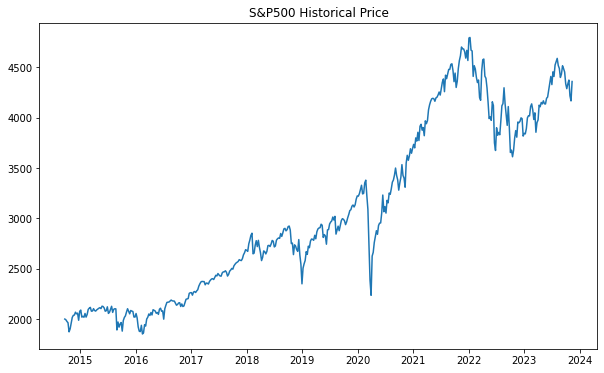

In [8]:
plt.figure(figsize=(10,6))
plt.plot(data['^GSPC'])
plt.title('S&P500 Historical Price')
plt.show()

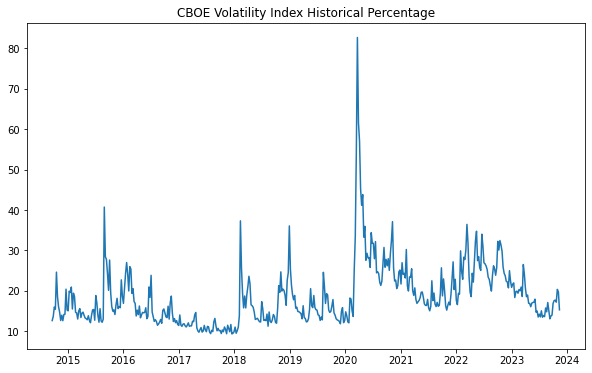

In [9]:
plt.figure(figsize=(10,6))
plt.plot(data['^VIX'])
plt.title('CBOE Volatility Index Historical Percentage')
plt.show()

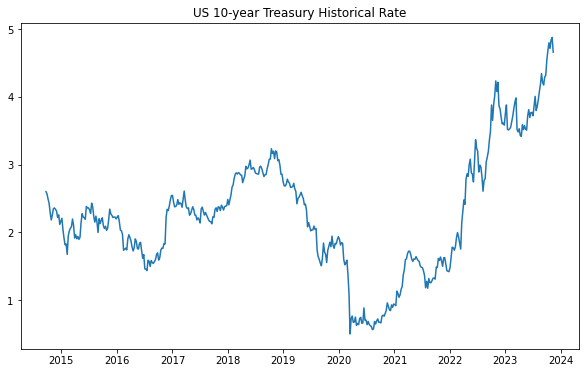

In [10]:
plt.figure(figsize=(10,6))
plt.plot(data['^TNX'])
plt.title('US 10-year Treasury Historical Rate')
plt.show()

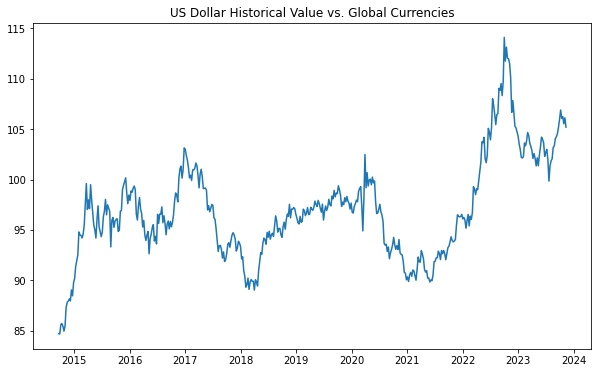

In [11]:
plt.figure(figsize=(10,6))
plt.plot(data['DX-Y.NYB'])
plt.title('US Dollar Historical Value vs. Global Currencies')
plt.show()

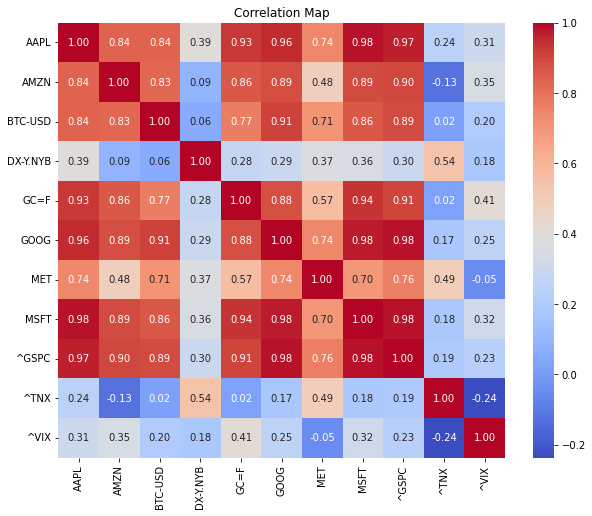

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Map")
plt.show()

In [13]:
def LogDiff(x):
    x_diff = 100*np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff

df_BTC = pd.DataFrame({'Bitcoin': data['BTC-USD'],
                   'BTC_1st_diff': data['BTC-USD'].diff(),
                   'dBTC': LogDiff(data['BTC-USD'])})

df_BTC = df_BTC.dropna()

df_BTC.head()

Bitcoin  BTC_1st_diff       dBTC
Date                                           
2014-09-28  402.152008    -55.182007 -12.858386
2014-10-05  375.467010    -26.684998  -6.865953
2014-10-12  330.079010    -45.388000 -12.883856
2014-10-19  390.414001     60.334991  16.787567
2014-10-26  382.845001     -7.569000  -1.957751

In [14]:
df_gold = pd.DataFrame({'Gold': data['GC=F'],
                   'Gold_1st_diff': data['GC=F'].diff(),
                   'dGold': LogDiff(data['GC=F'])})

df_gold = df_gold.dropna()

df_gold.head()

Gold  Gold_1st_diff     dGold
Date                                            
2014-09-28  1216.800049     -17.599976 -1.436054
2014-10-05  1217.500000       0.699951  0.057507
2014-10-12  1206.699951     -10.800049 -0.891026
2014-10-19  1229.300049      22.600098  1.855562
2014-10-26  1244.000000      14.699951  1.188705

In [15]:
def is_stationary(df, alpha=0.05):
    for column in df.columns:
        result = adfuller(df[column])
        test_statistic, p_value = result[0], result[1]
        print(f'Column: {column}')
        print(f'Test Statistic: %5f' %test_statistic)
        print(f'P-value: %5f' %p_value)
        
        if p_value <= alpha:
            print("Reject the null hypothesis. The data is stationary.")
        else:
            print("Fail to reject the null hypothesis. The data is not stationary.")
        print("")

# Assuming 'data' is your DataFrame with columns you want to test
is_stationary(df_BTC)

Column: Bitcoin
Test Statistic: -1.257020
P-value: 0.648599
Fail to reject the null hypothesis. The data is not stationary.

Column: BTC_1st_diff
Test Statistic: -21.014036
P-value: 0.000000
Reject the null hypothesis. The data is stationary.

Column: dBTC
Test Statistic: -20.776186
P-value: 0.000000
Reject the null hypothesis. The data is stationary.



In [16]:
# Assuming 'data' is your DataFrame with columns you want to test
is_stationary(df_gold)

Column: Gold
Test Statistic: -0.635877
P-value: 0.862667
Fail to reject the null hypothesis. The data is not stationary.

Column: Gold_1st_diff
Test Statistic: -23.370935
P-value: 0.000000
Reject the null hypothesis. The data is stationary.

Column: dGold
Test Statistic: -23.110168
P-value: 0.000000
Reject the null hypothesis. The data is stationary.



In [17]:
GAFAM['lGOOG'] = GAFAM['GOOG'].apply(lambda x : np.log(x))
GAFAM['lAAPL'] = GAFAM['AAPL'].apply(lambda x : np.log(x))
GAFAM['lMET'] = GAFAM['MET'].apply(lambda x : np.log(x))
GAFAM['lAMZN'] = GAFAM['AMZN'].apply(lambda x : np.log(x))
GAFAM['lMSFT'] = GAFAM['MSFT'].apply(lambda x : np.log(x))
GAFAM['GSPC'] = data['^GSPC']
GAFAM['lGSPC'] = GAFAM['GSPC'].apply(lambda x : np.log(x))

GAFAM = GAFAM.dropna()

GAFAM.head()

formula_log = 'lGSPC ~ lGOOG + lAAPL + lMET + lMSFT + lGSPC'
res_lGAFAM = sm.formula.ols(formula_log, GAFAM).fit()

lGAFAM_residual = res_lGAFAM.resid
lGAFAM_fit = res_lGAFAM.fittedvalues

In [18]:
GAFAM['dGOOG'] = LogDiff(GAFAM['GOOG'])
GAFAM['dAAPL'] = LogDiff(GAFAM['AAPL'])
GAFAM['dMET'] = LogDiff(GAFAM['MET'])
GAFAM['dAMZN'] = LogDiff(GAFAM['AMZN'])
GAFAM['dMSFT'] = LogDiff(GAFAM['MSFT'])
GAFAM['dGSPC'] = LogDiff(data['^GSPC'])

GAFAM = GAFAM.dropna()

formula_ret = 'dGSPC ~ dGOOG + dAAPL + dMET + dMSFT + dGSPC'
res_rGAFAM = sm.formula.ols(formula_ret, GAFAM).fit()

rGAFAM_residual = res_rGAFAM.resid
rGAFAM_fit = res_rGAFAM.fittedvalues

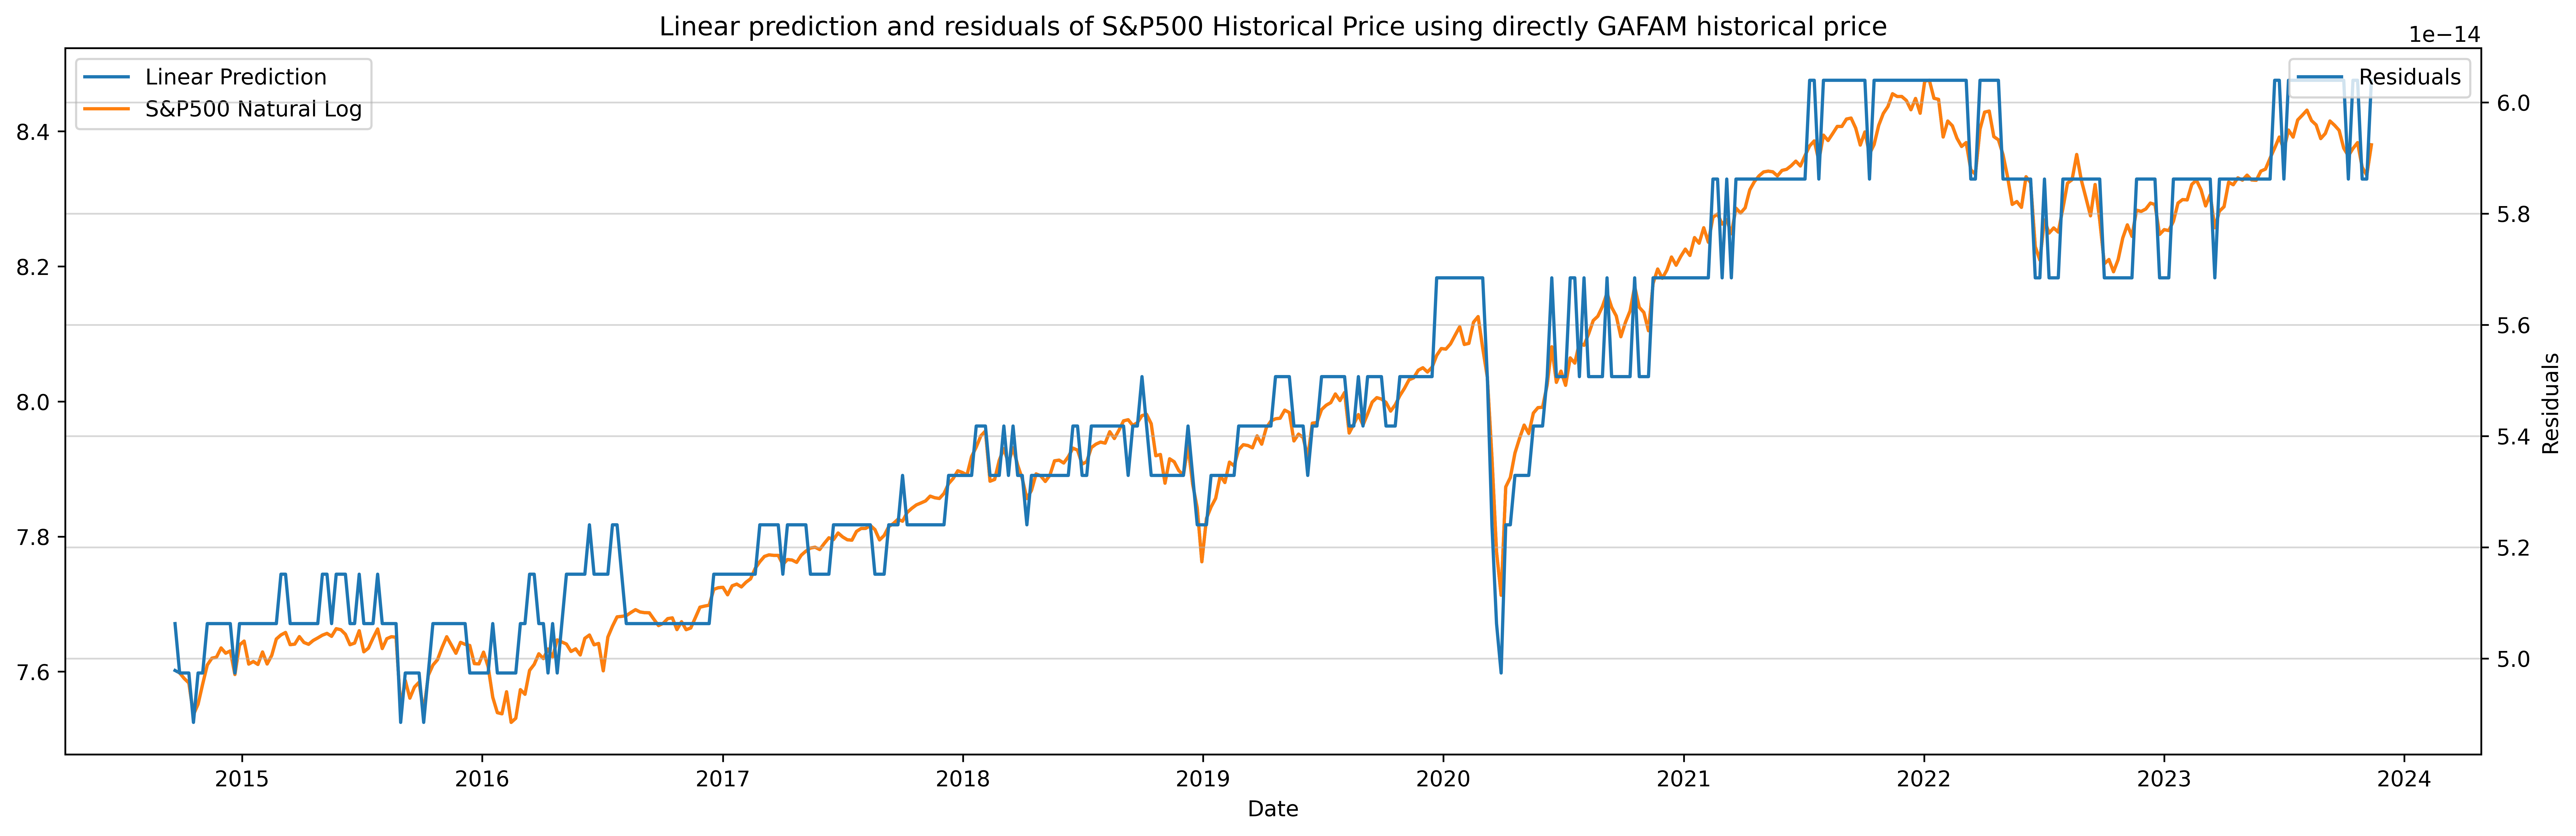

In [19]:
fig = plt.figure(1, figsize=(20,6), dpi=600)
ax1 = fig.add_subplot(111)
ax1.plot(lGAFAM_fit, label='Linear Prediction')
ax1.plot(GAFAM['lGSPC'], label='S&P500 Natural Log')
ax1.set_xlabel('Date')
ax1.legend(loc="upper left")

ax2 = plt.twinx()
ax2.set_ylabel('Residuals')
ax2.plot(lGAFAM_residual, label='Residuals')
ax2.legend(loc="upper right")

plt.title("Linear prediction and residuals of S&P500 Historical Price using directly GAFAM historical price")
plt.grid(1, alpha=0.5)
plt.show()

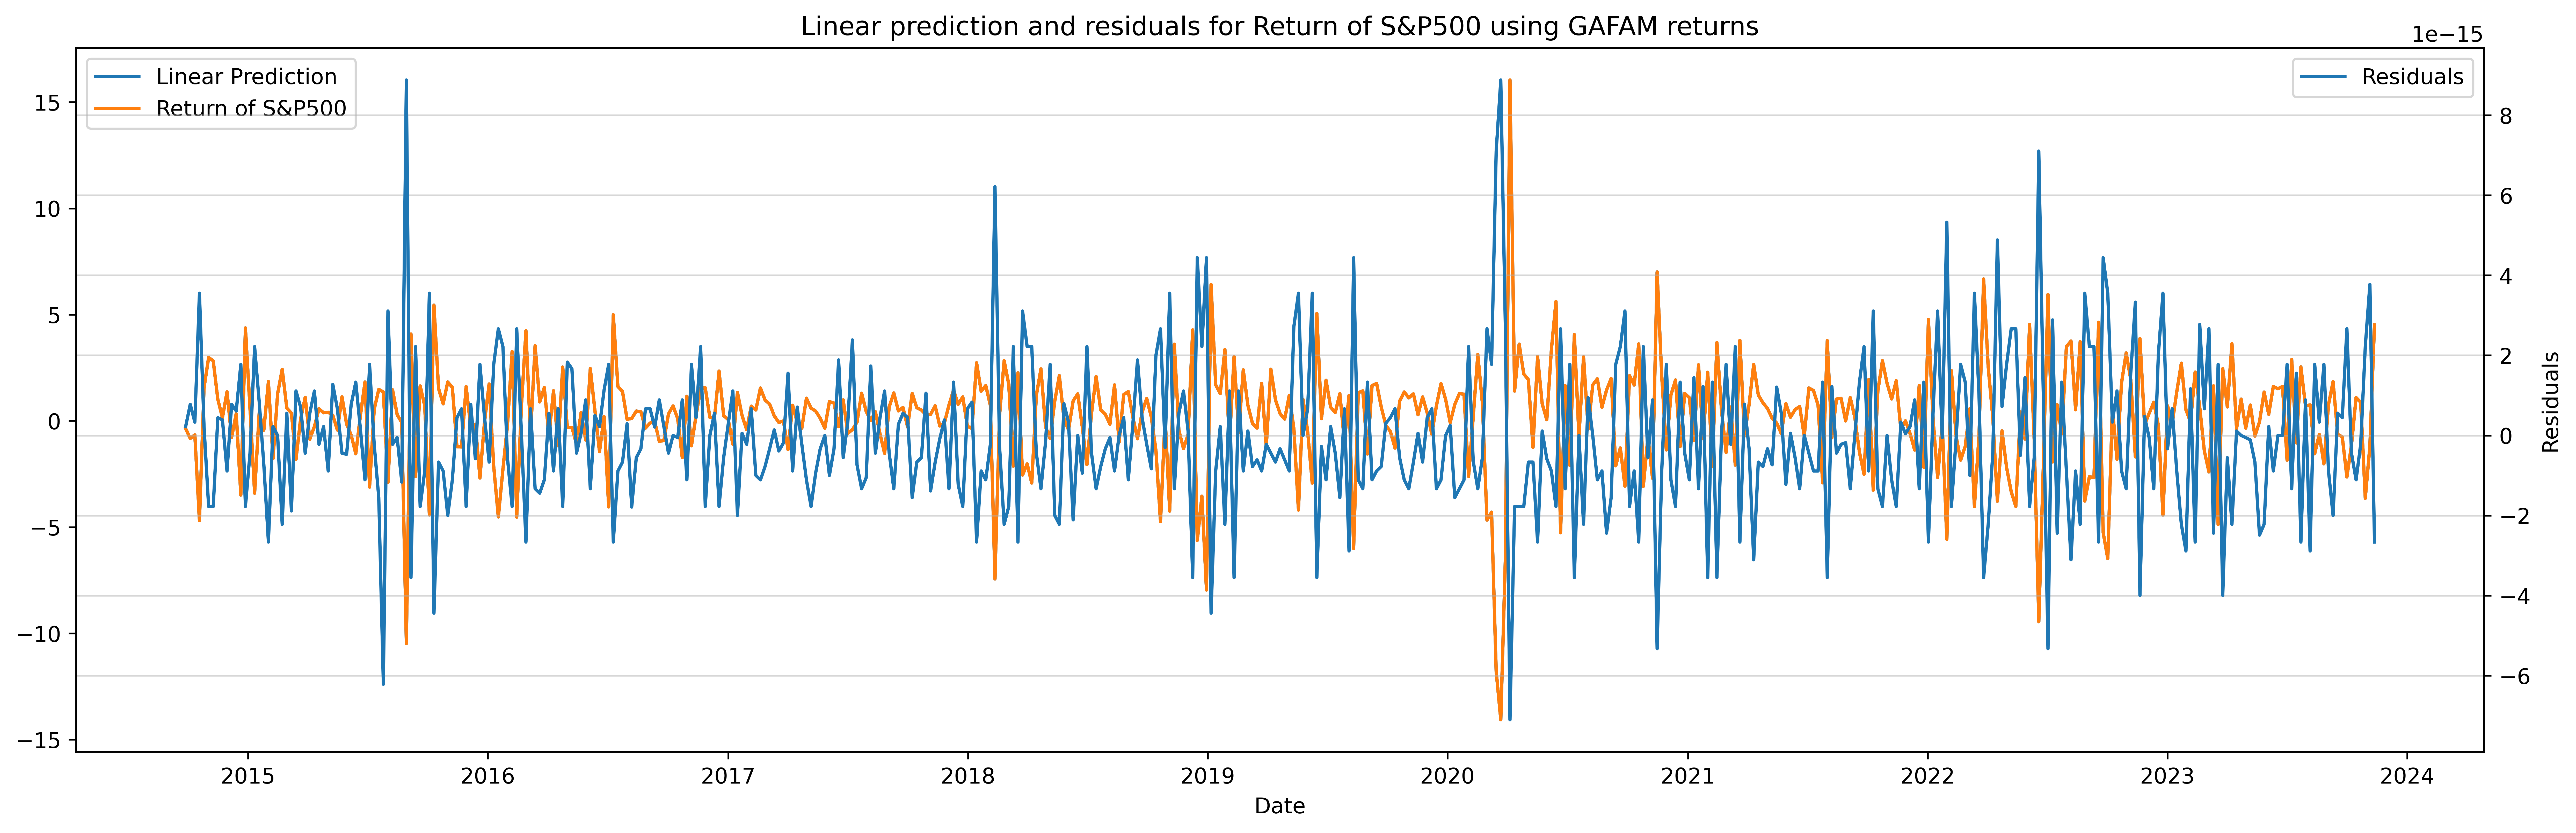

In [20]:
fig = plt.figure(1, figsize=(20,6), dpi=600)
ax1 = fig.add_subplot(111)
ax1.plot(rGAFAM_fit, label='Linear Prediction')
ax1.plot(GAFAM['dGSPC'], label='Return of S&P500')
ax1.set_xlabel('Date') 
ax1.legend(loc="upper left")  

ax2 = plt.twinx()
ax2.set_ylabel('Residuals')
ax2.plot(rGAFAM_residual, label='Residuals')
ax2.legend(loc="upper right") 

plt.title("Linear prediction and residuals for Return of S&P500 using GAFAM returns")
plt.grid(1, alpha=0.5)
plt.show()

In [26]:
def series_stationary(series, alpha=0.05):
    result = adfuller(series)
    test_statistic, p_value = result[0], result[1]
    
    print(f'Test Statistic: {test_statistic:.5f}')
    print(f'P-value: {p_value:.5f}')

    if p_value <= alpha:
        print("Reject the null hypothesis. The data is stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is not stationary.")
        
# Usage:
print("Residuals of S&P500 Natural Log Linear Prediction")
series_stationary(lGAFAM_residual)

Test Statistic: -2.07755
P-value: 0.25364
Fail to reject the null hypothesis. The data is not stationary.


In [28]:
print("Residuals of S&P500 Return Linear Prediction")
series_stationary(rGAFAM_residual)

Residuals of S&P500 Return Linear Prediction
Test Statistic: -23.52076
P-value: 0.00000
Reject the null hypothesis. The data is stationary.


In [42]:
formula_ret_log = 'dGSPC ~ dGOOG + dAAPL + dMET + dMSFT + dGSPC + lGOOG + lAAPL + lMET + lMSFT + lGSPC'
res_rlGAFAM = sm.formula.ols(formula_ret_log, GAFAM).fit()

rlGAFAM_residual = res_rlGAFAM.resid
rlGAFAM_fit = res_rlGAFAM.fittedvalues

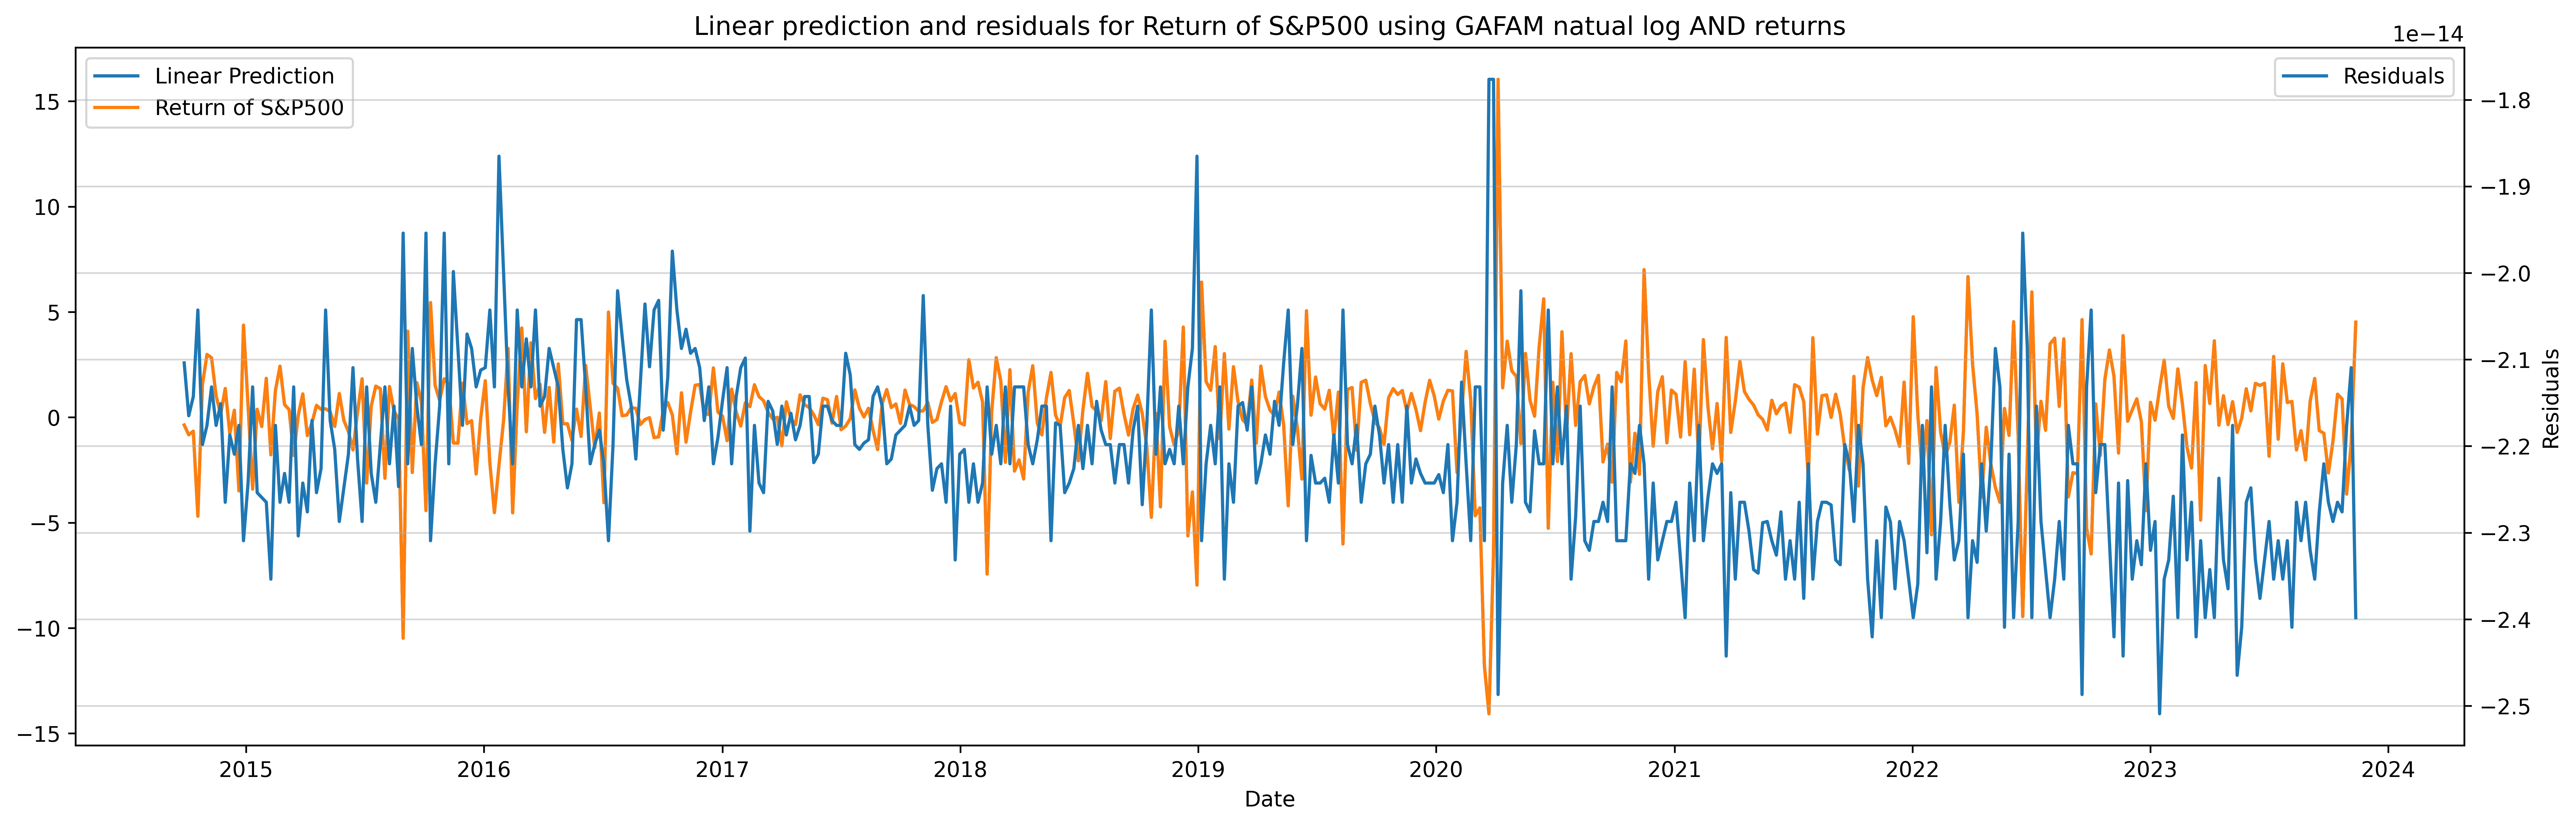

In [43]:
fig = plt.figure(1, figsize=(20,6), dpi=600)
ax1 = fig.add_subplot(111)
ax1.plot(rlGAFAM_fit, label='Linear Prediction')
ax1.plot(GAFAM['dGSPC'], label='Return of S&P500')
ax1.set_xlabel('Date') 
ax1.legend(loc="upper left")  

ax2 = plt.twinx()
ax2.set_ylabel('Residuals')
ax2.plot(rlGAFAM_residual, label='Residuals')
ax2.legend(loc="upper right") 

plt.title("Linear prediction and residuals for Return of S&P500 using GAFAM natual log AND returns")
plt.grid(1, alpha=0.5)
plt.show()

In [46]:
print("Residuals of S&P500 Return AND Natural Log Linear Prediction")
series_stationary(rlGAFAM_residual)

Residuals of S&P500 Return AND Natural Log Linear Prediction
Test Statistic: -16.60429
P-value: 0.00000
Reject the null hypothesis. The data is stationary.


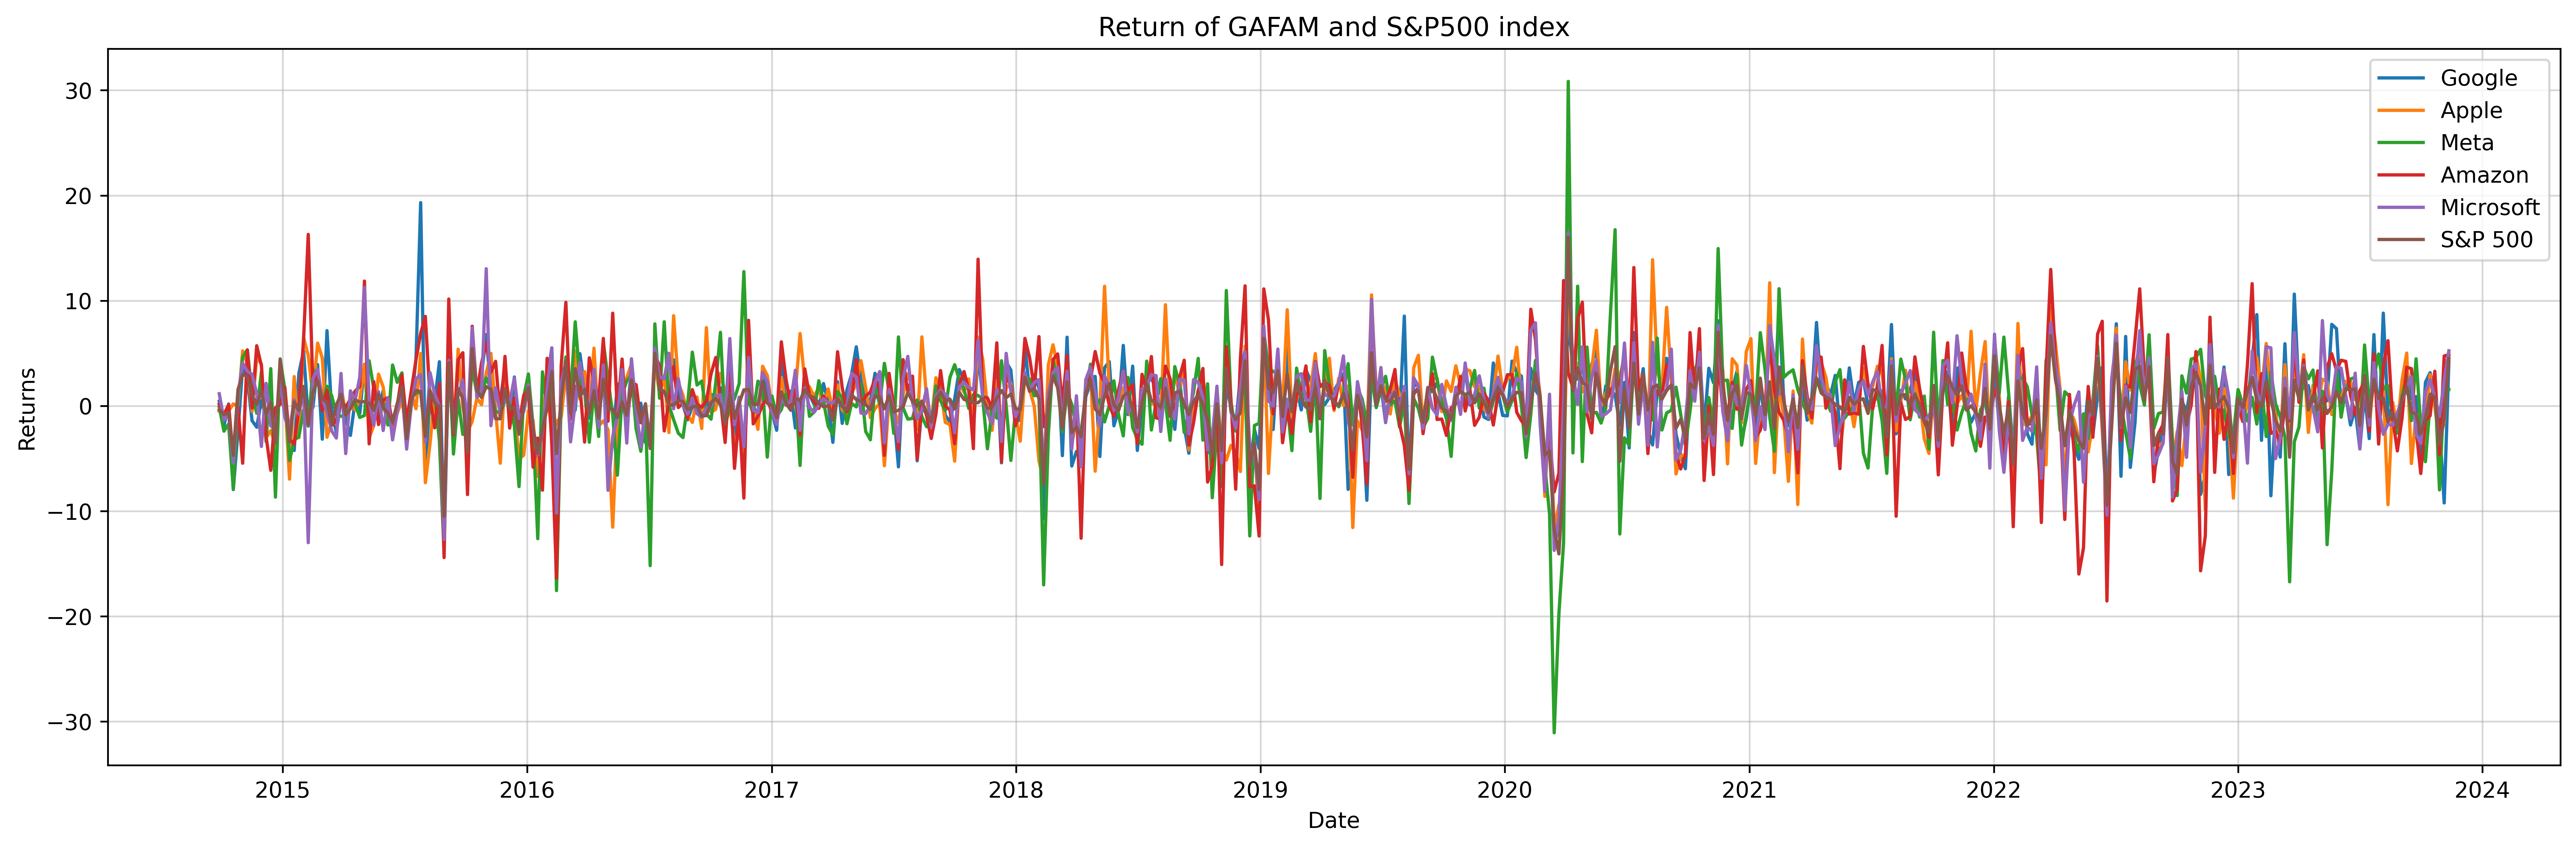

In [39]:
plt.figure(1, figsize=(20,6), dpi=600)
plt.plot(GAFAM['dGOOG'], label='Google')
plt.plot(GAFAM['dAAPL'], label='Apple')
plt.plot(GAFAM['dMET'], label='Meta')
plt.plot(GAFAM['dAMZN'], label='Amazon')
plt.plot(GAFAM['dMSFT'], label='Microsoft')
plt.plot(GAFAM['dGSPC'], label='S&P 500')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title("Return of GAFAM and S&P500 index")
plt.grid(True, alpha=0.5)
plt.show()

In [68]:
from statsmodels.tsa.vector_ar import vecm

vecm_GAFAM = pd.DataFrame({'dGOOG': GAFAM['dGOOG'],
                           'dAAPL': GAFAM['dAAPL'],
                           'dMET': GAFAM['dMET'],
                           'dAMZN': GAFAM['dAMZN'],
                           'dMSFT': GAFAM['dMSFT'],
                           'dGSPC': GAFAM['dGSPC']})

rank_maxeig = vecm.select_coint_rank(vecm_GAFAM, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(rank_maxeig.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          244.6          49.41
  1   2          226.6          42.86
  2   3          221.4          36.19
  3   4          197.4          29.26
  4   5          176.3          21.75
  5   6          164.9          6.635
-------------------------------------


In [69]:
rank_trace = vecm.select_coint_rank(vecm_GAFAM, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(rank_trace.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          1231.          117.0
  1   6          986.6          87.77
  2   6          760.0          62.52
  3   6          538.6          41.08
  4   6          341.2          23.15
  5   6          164.9          6.635
-------------------------------------


In [76]:
rank_coint = vecm.VECM(vecm_GAFAM.head(460), k_ar_diff=1, coint_rank=1 ,deterministic='coli', seasons=0)
res_coli = rank_coint.fit()
print(res_coli.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation dGOOG
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0145      0.208      0.070      0.945      -0.394       0.423
L1.dGOOG      -0.6259      0.062    -10.069      0.000      -0.748      -0.504
L1.dAAPL       0.0191      0.057      0.338      0.735      -0.092       0.130
L1.dMET        0.1565      0.058      2.709      0.007       0.043       0.270
L1.dAMZN       0.0053      0.050      0.106      0.916      -0.093       0.103
L1.dMSFT       0.4576      0.092      4.991      0.000       0.278       0.637
L1.dGSPC      -0.5531      0.164     -3.371      0.001      -0.875      -0.232
Det. terms outside the coint. relation & lagged endog. parameters for equation dAAPL
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [78]:
allpred = res_coli.predict(10)
pred = []
for step in allpred:
    pred.append(step[1])

pred

[1.0734369364467682,
 -0.0007509186594444328,
 0.3752562046701606,
 0.22017093020493927,
 0.2833276995484014,
 0.27216255841176423,
 0.27408029091636915,
 0.2803393535978451,
 0.28059208298834293,
 0.28514833321400257]